# Assignment 2 - CISC 351
### Mike Cruickshank (10130161)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Import Data:

In [2]:
df_train = pd.read_csv('house_price_train.csv')
df_test = pd.read_csv('house_price_test.csv')

## Problem 1)

Analyze distribution of the house price in training data:

In [3]:
print('Number of houses: %d' % df_train['price'].count())
print('Min house value: $%d' % df_train['price'].min())
print('Max house value: $%d' % df_train['price'].max())
print('Mean house value: $%d' % df_train['price'].mean())
print('Median house value: $%d' % df_train['price'].median())
print('Std of house value: $%d' % df_train['price'].std())


Number of houses: 20000
Min house value: $75000
Max house value: $7700000
Mean house value: $535473
Median house value: $449950
Std of house value: $365948


Text(2000000.0, 2500, 'Total Number of Houses: 20000')

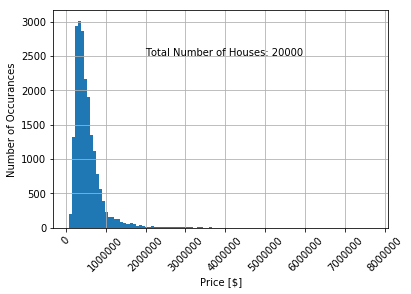

In [4]:
plt.hist(df_train['price'], bins = 100)
plt.xticks(rotation=45)
plt.xlabel('Price [$]')
plt.ylabel('Number of Occurances')
plt.grid()
plt.text(2e6,2500, 'Total Number of Houses: %d' % df_train['price'].count())

The vast majority of house prices are distributed below 1 000 000. However there are some outliers that are much higher. 

    * The first plot below shows the distribution of houses with prices over 1 million. 
    * The second plot shows the opposite end of the spectrum, with prices below 200 000 (with a different bin size to better show the distribution in this range).

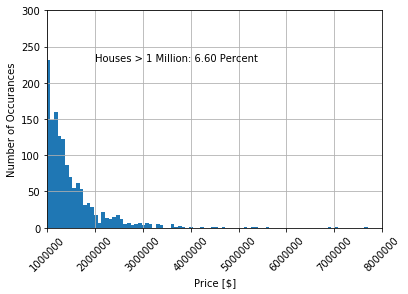

In [9]:
plt.hist(df_train['price'], bins = 100)
plt.xticks(rotation=45)
plt.xlabel('Price [$]')
plt.ylabel('Number of Occurances')
plt.axis([1e6, 8e6, 0, 300])
plt.grid()
p = 100* df_train[df_train > 1e6].count()['price']/df_train['price'].count()
plt.text(2e6,230, 'Houses > 1 Million: %.2f Percent' % p)
plt.show()



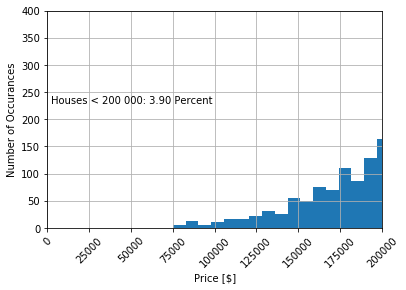

In [10]:
plt.hist(df_train['price'], bins = 1000)
plt.xticks(rotation=45)
plt.xlabel('Price [$]')
plt.ylabel('Number of Occurances')
plt.axis([0, 200e3, 0, 400])
plt.grid()
p = 100* df_train[df_train < 200e3].count()['price']/df_train['price'].count()
plt.text(2e3,230, 'Houses < 200 000: %.2f Percent' % p)
plt.show()

There is an obvious skew in the distribution of house prices. Most houses range from the minimum up to approximately 1.5 million. Past this range, there are only a few outliers but they have a large range of up to 7.7 million. This imbalance will be an important consideration while building regression models. 

Before analyzing for correlations, convert date to an integer value (days since Jan 1st 2010). 

  * This is done because the string format that the date is originally in is not very useful. 
  * The date will be important as the price of a house would be effected by inflation and housing market trends, both of which depend on time

In [11]:
def DateToNum(str):
    y = int(str[:4])
    m = int(str[4:6])
    d = int(str[6:8])
    return 365*(y-2010) + 30*(m-1) + d

In [12]:
df_train['date_num'] = 0
for i in range(np.size(df_train,0)):
    df_train.loc[i,'date_num'] = DateToNum(df_train.loc[i,'date'])


Analyze correlation between each feature and house price:

In [13]:
corr = df_train.corr()
print("Correlation coefficient with house price %: \n")
print(corr['price'].sort_values(ascending = False))

Correlation coefficient with house price %: 

price            1.000000
sqft_living      0.701237
grade            0.665403
sqft_above       0.604982
sqft_living15    0.595720
bathrooms        0.523939
view             0.400164
sqft_basement    0.321816
lat              0.309542
bedrooms         0.302262
floors           0.278863
waterfront       0.268705
yr_renovated     0.135626
sqft_lot         0.085830
sqft_lot15       0.077641
condition        0.047331
yr_built         0.040336
long             0.011760
date_num        -0.006922
id              -0.014968
zipcode         -0.044555
Name: price, dtype: float64


Based on the list of correlation values, the features that will likely NOT be useful for the house prediction task are:

* zipcode
* id (obvious, as each object will have different id)
* date_num
* long


Another feature that could be transformed is zipcode. In the original format, zipcod will not have much value. If each zipcode could be mapped to a value such as median income in the zipcode based on census data, then it would likely be of more use for predicting the house price. 

Before moving on to building models, check the correlation and VIF between the features to see if any of the features listed above should be removed. It is likely that some of the sqft features are highly correlated with each other.

In [14]:
import seaborn as sns

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 <a list of 21 Text xticklabel objects>)

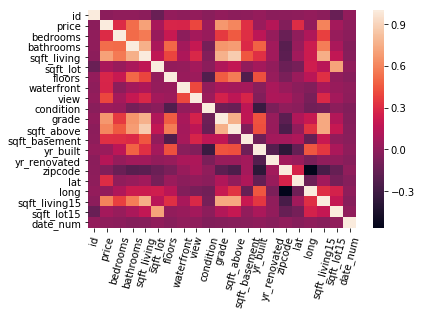

In [15]:
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True 

sns.heatmap(corr)
plt.xticks(rotation=75)


In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

x = df_train.select_dtypes(exclude=['object'])
                 
vif = pd.DataFrame()
vif["features"] = x.columns
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif.round(2)

C:\Users\Mike\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,features,VIF Factor
0,id,3.640000
1,price,3.350000
2,bedrooms,1.640000
3,bathrooms,3.330000
4,sqft_living,inf
5,sqft_lot,2.040000
6,floors,1.930000
7,waterfront,1.270000
8,view,1.460000
9,condition,1.200000


Based on the correlation map and the VIF list presented above, it is evident that sqft_above, sqft_basement and sqft_living are linear combinations. By removing sqft_living, the VIF values are resonable:

In [17]:
x = x.drop(labels = 'sqft_living', axis = 1)
                 
vif = pd.DataFrame()
vif["features"] = x.columns
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif.round(2)

,features,VIF Factor
0,id,3.64
1,price,3.35
2,bedrooms,1.64
3,bathrooms,3.33
4,sqft_lot,2.04
5,floors,1.93
6,waterfront,1.27
7,view,1.46
8,condition,1.20
9,grade,3.73


### Problem 2)

Features to use:

In [18]:
features = ['sqft_lot','sqft_above',
            'sqft_basement','sqft_living15','sqft_lot15',
            'grade','bedrooms','view','bathrooms','lat',
            'floors','waterfront','condition','yr_built']

Based on selected features in section 1, create three models (rf, gbm, xgboost) to predict house prices.

In [19]:
df_train_features = df_train[features]
df_train_target = df_train['price']


Transform test data using same procedure that was used for the training data (unnecessary if we are only using the features listed above):

In [20]:
df_test['date_num'] = 0
for i in range(np.size(df_test,0)):
    df_test.loc[i,'date_num'] = DateToNum(df_test.loc[i,'date'])


In [21]:

df_test_features = df_test[features]
df_test_target = df_test['price']


To compare the three models, three metrics will be used: R-squared value, root mean squared error (RMSE) and mean absolute error

 * R-sqruared was choosen as it is describes how well the model performs on the test data
 * MAE was choosen as it provides a value for the error that can easily be interpreted with some domain knowledge (i.e. a MAE of 20 000 may not be much for a  house, but would be a large error for problems rooted in other domains)
 * RMSE was choosen as it places particular importance on the large errors (as it takes the mean of the squares, then applies the square root opperation)

In [22]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

#### Random Forest:

The first model created is a random forest.  A series of trial and error tests were performed to determine the combination that would provide the best performance on the test set.
* Number of estimators = 200 (number of trees to grow in RF)
* Max Depth = 15 (maximum depth of trees in RF, used to avoid overfitting)
* Min samples split = 12 (Minimum number of samples to split a node)

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 200, max_depth = 14,
                          min_samples_split = 20)
rf.fit(df_train_features, df_train_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [24]:
rf_test_pred = rf.predict(df_test_features)
rf_train_pred = rf.predict(df_train_features)


In [26]:
rf_r2_test = r2_score(df_test_target, rf_test_pred)
rf_mae_test = mean_absolute_error(df_test_target, rf_test_pred)
rf_mse_test = mean_squared_error(df_test_target, rf_test_pred)
rf_rmse_test = np.sqrt(rf_mse_test)

rf_r2_train = r2_score(df_train_target, rf_train_pred)
rf_mae_train = mean_absolute_error(df_train_target, rf_train_pred)
rf_mse_train = mean_squared_error(df_train_target, rf_train_pred)
rf_rmse_train = np.sqrt(rf_mse_train)

print('Random Forest on Train Set: R^2 = %.2f, MAE = %.2f, RMSE = %.2f' % (rf_r2_train,rf_mae_train, rf_rmse_train))
print('Random Forest on Test Set: R^2 = %.2f, MAE = %.2f, RMSE = %.2f' % (rf_r2_test,rf_mae_test, rf_rmse_test))


Random Forest on Train Set: R^2 = 0.90, MAE = 61984.35, RMSE = 116320.97
Random Forest on Test Set: R^2 = 0.78, MAE = 90210.37, RMSE = 177707.30


#### Gradient Boosting Machine:

The second model created is a gradient boosting machine. A series of trial and error tests were performed to determine the combination that would provide the best performance on the test set.

* Number of estimators = 200 (number of boosting stages)
* Learning rate = 0.2 (rate at which each successive model's contribution is decreased)
* Subsample = 0.9 (fraction of training samples used for each model)
* Minimum samples split = 100 (minimum number of samples required to split a node)
* Max depth = 5 (Maximum depth of trees used)

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators = 200, subsample = 0.9,
                                learning_rate = 0.2, min_samples_split = 100,
                                max_depth = 6)
gbr.fit(df_train_features, df_train_target)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=100, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=0.9, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [35]:
gbr_test_pred = gbr.predict(df_test_features)
gbr_train_pred = gbr.predict(df_train_features)

In [36]:
gbr_r2_test = r2_score(df_test_target, gbr_test_pred)
gbr_mae_test = mean_absolute_error(df_test_target, gbr_test_pred)
gbr_mse_test = mean_squared_error(df_test_target, gbr_test_pred)
gbr_rmse_test = np.sqrt(gbr_mse_test)

gbr_r2_train = r2_score(df_train_target, gbr_train_pred)
gbr_mae_train = mean_absolute_error(df_train_target, gbr_train_pred)
gbr_mse_train = mean_squared_error(df_train_target, gbr_train_pred)
gbr_rmse_train = np.sqrt(gbr_mse_train)

print('GBM on Train Set: R^2 = %.2f, MAE = %.2f, RMSE = %.2f' % (gbr_r2_train,gbr_mae_train, gbr_rmse_train))
print('GBM on Test Set: R^2 = %.2f, MAE = %.2f, RMSE = %.2f' % (gbr_r2_test,gbr_mae_test, gbr_rmse_test))

GBM on Train Set: R^2 = 0.95, MAE = 57921.38, RMSE = 83812.70
GBM on Test Set: R^2 = 0.79, MAE = 87620.08, RMSE = 174319.69


#### Xgboost:

The third and final model created uses xgboost. A series of trial and error tests were performed to determine the combination that would provide the best performance on the test set.

* Number of estimators = 200 (number of boosting stages)
* Minimum samples split = 100 (minimum number of samples required to split a node)
* Max depth = 5 (Maximum depth of trees used)

In [30]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators = 200, max_depth = 5,
                  min_samples_split = 100)
xgb.fit(df_train_features, df_train_target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, min_samples_split=100,
       missing=None, n_estimators=200, n_jobs=1, nthread=None,
       objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=None, silent=True, subsample=1)

In [31]:
xgb_test_pred = xgb.predict(df_test_features)
xgb_train_pred = xgb.predict(df_train_features)

In [32]:
xgb_r2_test = r2_score(df_test_target, xgb_test_pred)
xgb_mae_test = mean_absolute_error(df_test_target, xgb_test_pred)
xgb_mse_test = mean_squared_error(df_test_target, xgb_test_pred)
xgb_rmse_test = np.sqrt(xgb_mse_test)

xgb_r2_train = r2_score(df_train_target, xgb_train_pred)
xgb_mae_train = mean_absolute_error(df_train_target, xgb_train_pred)
xgb_mse_train = mean_squared_error(df_train_target, xgb_train_pred)
xgb_rmse_train = np.sqrt(xgb_mse_train)

print('Xgboost on Train Set: R^2 = %.2f, MAE = %.2f, RMSE = %.2f' % (xgb_r2_train,xgb_mae_train, xgb_rmse_train))
print('Xgboost on Test Set: R^2 = %.2f, MAE = %.2f, RMSE = %.2f' % (xgb_r2_test,xgb_mae_test, xgb_rmse_test))

Xgboost on Train Set: R^2 = 0.93, MAE = 63188.97, RMSE = 94965.35
Xgboost on Test Set: R^2 = 0.83, MAE = 82250.14, RMSE = 157441.25


#### Model Comparison:

To comare the three models, the three evaluation metrics for each model are displayed in the table below. For visualization, a plot of the comparing the predicted price (from each model) to the actual price from the test set is displayed.

In [53]:
err = np.zeros((3,3))
err[:,0] = np.array([rf_r2_test,gbr_r2_test,xgb_r2_test])
err[:,1] = np.array([rf_mae_test,gbr_mae_test,xgb_mae_test])
err[:,2] = np.array([rf_rmse_test,gbr_rmse_test,xgb_rmse_test])



err_name = ['R-squared','Mean Absolute Error','Root Mean Squared Error']
model_name = ['Random Forest','GBM','Xgboost']
results = pd.DataFrame(err, model_name, err_name)

results.style.format({'R-squared':'{:.2f}','Mean Absolute Error':'{:.0f}','Root Mean Squared Error':'{:.0f}'})
results.head()

,R-squared,Mean Absolute Error,Root Mean Squared Error
Random Forest,0.777543,90210.372351,177707.299007
GBM,0.785943,87620.084286,174319.686755
Xgboost,0.825388,82250.142824,157441.249919


It is clear that xgboost is the best model. It is superior in all three metrics considered. 

C:\Users\Mike\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\Mike\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\Mike\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDep

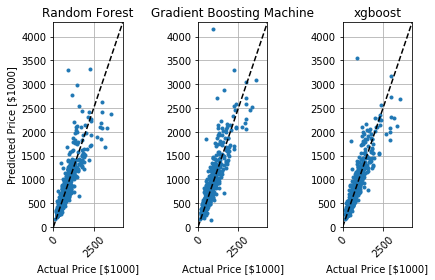

In [38]:
plt.subplot(1,3,1)
plt.plot(1e-3*df_test_target,1e-3*rf_test_pred,'.')
plt.ylabel('Predicted Price [$1000]')
plt.title('Random Forest')

plt.subplot(1,3,2)
plt.plot(1e-3*df_test_target,1e-3*gbr_test_pred,'.')
plt.title('Gradient Boosting Machine')

plt.subplot(1,3,3)
plt.plot(1e-3*df_test_target,1e-3*xgb_test_pred,'.')
plt.title('xgboost')

m = np.max([np.max(df_test_target),np.max(rf_test_pred),np.max(gbr_test_pred),np.max(xgb_test_pred)])
m = np.round(m+1e5,-5)

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.grid()
    plt.axis([0, 1e-3*m, 0, 1e-3*m])
    plt.plot(1e-3*np.linspace(0,m,100),1e-3*np.linspace(0,m,100),'k--')
    plt.xticks(rotation=45)
    plt.xlabel('Actual Price [$1000]')

plt.tight_layout()
plt.show()

### Important Features 

In [42]:
from sklearn.feature_selection import RFE

def RankFeatures(model):
    rfe = RFE(model, n_features_to_select = 1, verbose = 3)
    rfe = rfe.fit(df_train_features,df_train_target)
    vals = np.argsort(rfe.ranking_)
    ranked_features = []
    for i in vals:
        ranked_features.append(features[i])
    return ranked_features

In [43]:
rankedFeatures_rf = RankFeatures(model = rf)
rankedFeatures_gbr = RankFeatures(model = gbr)
rankedFeatures_xgb = RankFeatures(model = xgb)

Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting 

In [44]:

df_rank = pd.DataFrame({'Feature Rank' : np.arange(len(features))+1,
                        'Random Forest' : rankedFeatures_rf,
                        'GBM' : rankedFeatures_gbr,
                        'xgboost' : rankedFeatures_xgb})
df_rank.head(-1)

,Feature Rank,Random Forest,GBM,xgboost
0,1,grade,grade,sqft_lot
1,2,lat,lat,lat
2,3,sqft_above,sqft_above,sqft_above
3,4,yr_built,yr_built,sqft_living15
4,5,sqft_living15,bathrooms,sqft_lot15
5,6,bathrooms,sqft_living15,yr_built
6,7,waterfront,sqft_basement,sqft_basement
7,8,sqft_basement,waterfront,grade
8,9,sqft_lot,view,bathrooms
9,10,view,sqft_lot15,view


The list of features ranked by importance using recursive feature elimination is presented above. There are some interesting differences, such as grade being the most important in both random forest and GBM but only the 7th most important in xgboost. 